In [1]:
from make_dataloader import CustomDataset
from torch.utils.data import Dataset, DataLoader
import torchvision
train_2_dataset = CustomDataset('train', 'A2C', torchvision.transforms.ToTensor())
train_4_dataset = CustomDataset('train', 'A4C', torchvision.transforms.ToTensor())
val_2_dataset = CustomDataset('validation', 'A2C', torchvision.transforms.ToTensor())
val_4_dataset = CustomDataset('validation', 'A4C', torchvision.transforms.ToTensor())
train_2_4_dataset= []
test_2_4_dataset = []
for i in range(len(train_2_dataset)):
    train_2_4_dataset.append(train_2_dataset[i])
    train_2_4_dataset.append(train_4_dataset[i])
for j in range(len(val_2_dataset)):
    test_2_4_dataset.append(val_2_dataset[j])
    test_2_4_dataset.append(val_4_dataset[j])
    

train_loader= DataLoader(train_2_4_dataset, batch_size=8)
valid_loader= DataLoader(test_2_4_dataset, batch_size=8)
# train_2_dataloader = DataLoader(train_2_dataset, batch_size=40, shuffle=False)
# train_4_dataloader = DataLoader(train_2_dataset, batch_size=40, shuffle=False)
# val_2_dataloader = DataLoader(val_2_dataset, batch_size=40, shuffle=False)
# val_4_dataloader = DataLoader(val_4_dataset, batch_size=40, shuffle=False)


In [3]:
import matplotlib.pyplot as plt
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [2]:
image, mask = train_2_dataset[4]
mask.max()
# visualize(image=image, mask=mask)


tensor(1.0000)

In [6]:
mask.max()*255

tensor(1.0000)

In [8]:
import albumentations as albu

In [12]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [17]:
model = smp.UnetPlusPlus()
loss = smp.utils.losses.DiceLoss()
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
device = torch.device("cuda:0")
metrics = smp.utils.losses.DiceLoss()

In [20]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to C:\Users\dmlab/.cache\torch\hub\master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to C:\Users\dmlab/.cache\torch\hub\checkpoints\unet-e012d006.pt


In [21]:
print(model)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
from metrics import get_DC, get_JS
from tqdm import tqdm
import os
import numpy as np
def main(args):

    device = torch.device("cuda:0")

    loaders = {"train": train_loader, "valid": valid_loader}
    unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)

    unet.to(device)

    best_validation_dsc =np.inf 

    optimizer = torch.optim.Adam(unet.parameters(), lr=args.lr)

    loss_train = []
    loss_valid = []

    for epoch in tqdm(range(args.epochs), total=args.epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()


            for i, data in enumerate(loaders[phase]):

                x, y_true = data
                x, y_true = x.to(device), y_true.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)

                    loss = get_DC(y_pred, y_true)

                    if phase == "valid":
                        loss_valid.append(loss.item())

                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()

                if loss_valid[-1]< best_validation_dsc:
                    best_validation_dsc = loss_valid[-1] 
                    torch.save(unet.state_dict(), "unet.pth")
                loss_valid = []

    print("Best validation mean DSC: {:4f}".format(best_validation_dsc))

In [6]:
from unet import pretrained_unet
import torch
model = pretrained_unet(False)
model.load_state_dict(torch.load('./unet.pth'))
for (image, mask) in valid_loader:
    true = mask
    model = model.cuda()
    image = image.cuda()
    mask = model(image)
    mask_imt = (mask > 0.5)+0
    break


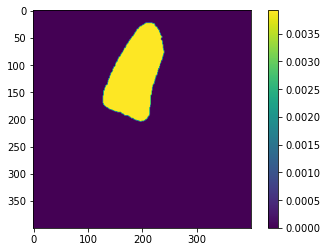

In [42]:
import matplotlib.pyplot as plt
plt.imshow(true[1].permute(1,2,0).cpu().detach().numpy())
plt.colorbar()

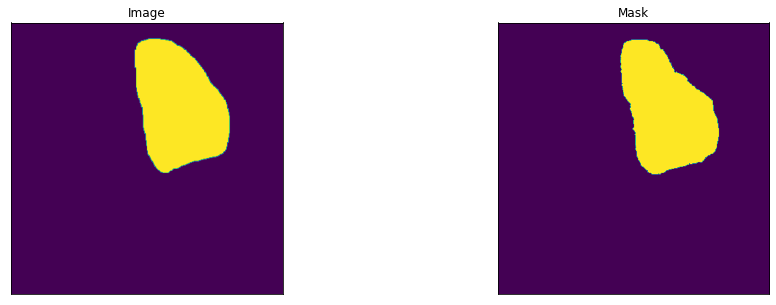

In [13]:
mask_int = (mask>0.001)+0
visualize(image=true[0].permute(1,2,0).cpu().detach().numpy(), mask = mask_int[0].permute(1,2,0).cpu().detach().numpy())


In [42]:
np.sum(mask_int.cpu().detach().numpy())

126358

In [36]:
import numpy as np
JS, Inter, Union, SR, GT = get_JS(mask[0].cpu().detach(), true[0].cpu().detach(), 0.001)


In [35]:

def get_JS(SR,GT,threshold=0.5):
    # JS : Jaccard similarity
    SR = SR > threshold
    
    Inter = torch.sum((SR+GT)==2)
    Union = torch.sum((SR+GT)>=1)
    
    JS = float(Inter)/(float(Union) + 1e-6)
    
    return JS, Inter, Union, SR, GT


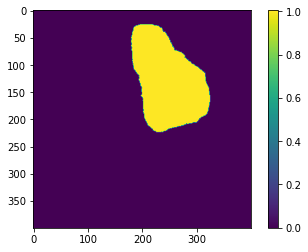

In [37]:
import matplotlib.pyplot as plt
plt.imshow((SR+GT).permute(1,2,0))
plt.colorbar()

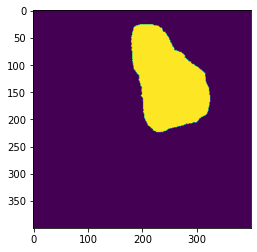

In [38]:
plt.imshow((SR).permute(1,2,0))

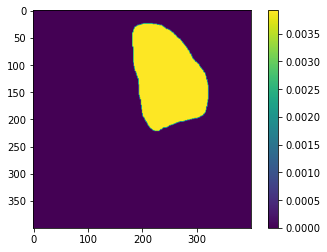

In [39]:

plt.imshow((GT).permute(1,2,0))
plt.colorbar()

In [41]:
print(GT.max())

tensor(0.0039)
